In [19]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import classification_report, f1_score
import warnings
from PIL import Image
import face_recognition
from scipy import misc
from sklearn.datasets import fetch_olivetti_faces
import seaborn as sns
sns.set_context("paper")
sns.set(style='darkgrid', font_scale=1.25)
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 4, 4

image_shape = (64, 64)

def get_imlist(path):
    """ Returns a list of filenames for all png images in a directory"""
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.png') or f.endswith('.jpg')]

def showfig(image, ax=None):
    if not ax:
        imgplot=imshow(image, cmap='gray')
        imgplot.axes.get_xaxis().set_visible(False)
        imgplot.axes.get_yaxis().set_visible(False)
    if ax:
        ax.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
def showfig2(image):
    imgplot=imshow(image, cmap='gray', interpolation='none')
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)

In [20]:
#set no. of rows that the images will be resized.
k1=64
#set no. of columns that the images will be resized.
k2=64


# Load the jpg file into a numpy array

def face_detect(path):
    image = face_recognition.load_image_file(path)

    # Find all the faces in the image using the default HOG-based model.
    # This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
    # See also: find_faces_in_picture_cnn.py
    face_locations = face_recognition.face_locations(image)

    print("I found {} face(s) in this photograph.".format(len(face_locations)))
    faces = np.array([])
    for face_location in face_locations:

        # Print the location of each face in this image
        top, right, bottom, left = face_location
        print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

        # You can access the actual face itself like this:
        face_image = image[top:bottom, left:right]
        pil_image = Image.fromarray(face_image).convert('L')
#         showfig(pil_image)
        pil_image1 = misc.imresize(pil_image, [k1,k2])
        if not faces.shape[0]:
            faces = np.array(pil_image1).flatten()
        else:
            faces = np.vstack([faces, np.array(pil_image1).flatten()])
        return faces

In [21]:
faces = fetch_olivetti_faces(shuffle=False, random_state=432542)
faces_images = faces.data
faces_images1 = np.copy(faces_images)
faces_ids = faces.target
image_shape = (64, 64)

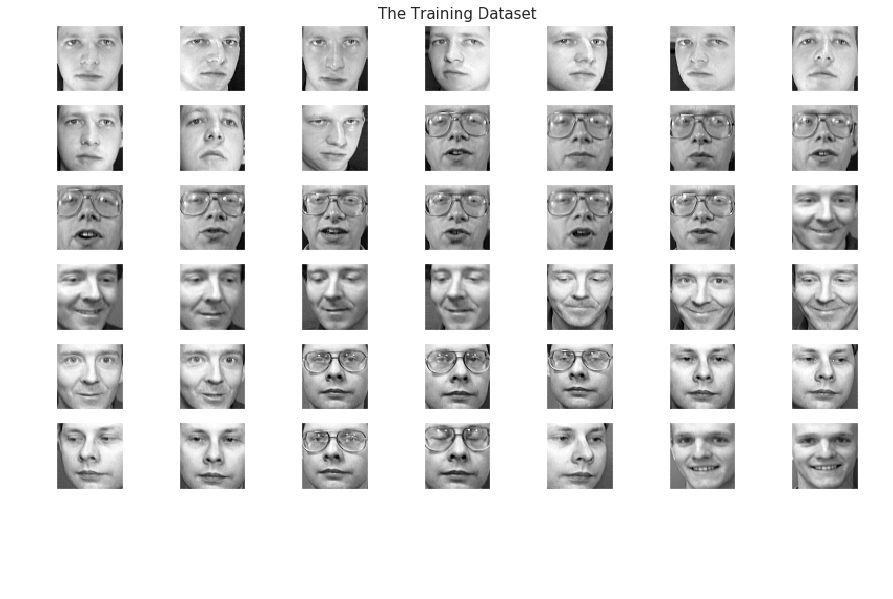

In [22]:
fig = plt.figure(figsize=(15, 10))
plt.title('The Training Dataset')
plt.axis("off")
for i in range(42):
    fig.add_subplot(7,7,i+1)
    showfig(faces_images[i,:].reshape(image_shape))

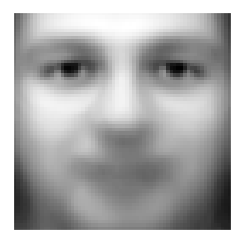

In [5]:
showfig(np.mean(faces_images, axis=0).reshape(image_shape))

I found 1 face(s) in this photograph.
A face is located at pixel location Top: 30, Left: 5, Bottom: 105, Right: 79
I found 1 face(s) in this photograph.
A face is located at pixel location Top: 32, Left: 17, Bottom: 94, Right: 80
I found 1 face(s) in this photograph.
A face is located at pixel location Top: 30, Left: 5, Bottom: 105, Right: 79
I found 1 face(s) in this photograph.
A face is located at pixel location Top: 30, Left: 5, Bottom: 105, Right: 79
I found 1 face(s) in this photograph.
A face is located at pixel location Top: 170, Left: 63, Bottom: 491, Right: 384


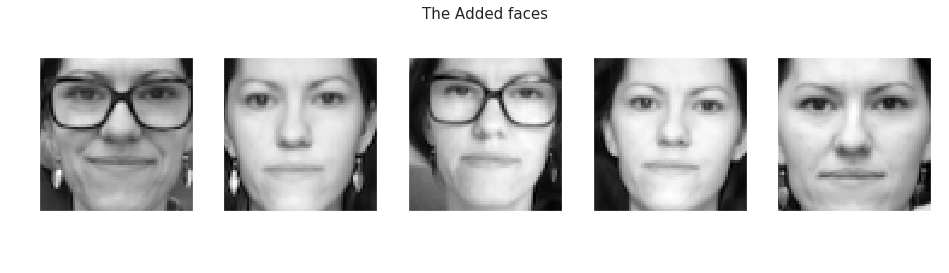

In [23]:
def scale(vec):
    return vec/vec.max()
    
def populate_train(path_train, faces_images, faces_ids):
    filenames = get_imlist(path_train)
    filenames = np.array(filenames)
    n=len(filenames)
    new_faces = face_detect(filenames[0])
    new_faces = scale(new_faces)
    for i in range(1,n):
        temp = face_detect(filenames[i])
        temp = scale(temp)
        new_faces = np.vstack([new_faces,temp])
        
    cnt = new_faces.shape[0]
    new_target = np.array([np.max(faces_ids)+1 for _ in range(cnt)])
    faces_images = np.vstack([faces_images,new_faces])
    faces_ids = np.concatenate((faces_ids,new_target), axis=None)

    fig = plt.figure(figsize=(16, 4))
    plt.title('The Added faces')
    plt.axis("off")
    for j in range(cnt):
        fig.add_subplot(1,cnt,j+1)
        showfig(new_faces[j,:].reshape(image_shape))
    return faces_images, faces_ids
path_train = "my_photo"
faces_images, faces_ids = populate_train(path_train, faces.data, faces.target)

In [24]:
faces_images.shape

(405, 4096)

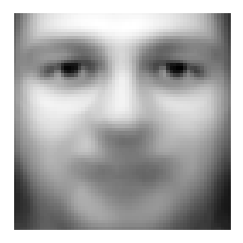

In [25]:
plt.rcParams['figure.figsize'] = 4, 4
mean_face = np.mean(faces_images, axis=0)
faces_images_centered = faces_images - mean_face
showfig(mean_face.reshape(image_shape))

In [26]:
B = np.copy(faces_images_centered.T)
r = np.linalg.matrix_rank(B)
u, s, vh = np.linalg.svd(B)

print('B shape:', B.shape)
print('U shape:', u.shape)
print('s shape:', s.shape)
print('Vh shape:', vh.shape)
print('rank of B:', r)
face_basis1 = u[:,:r]
print(face_basis1.shape)
# u, s, vh

B shape: (4096, 405)
U shape: (4096, 4096)
s shape: (405,)
Vh shape: (405, 405)
rank of B: 404
(4096, 404)


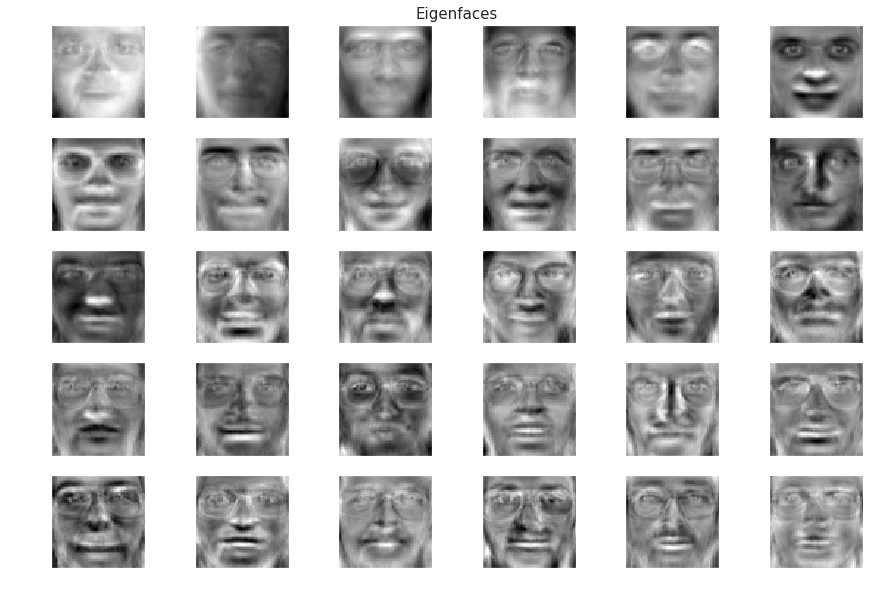

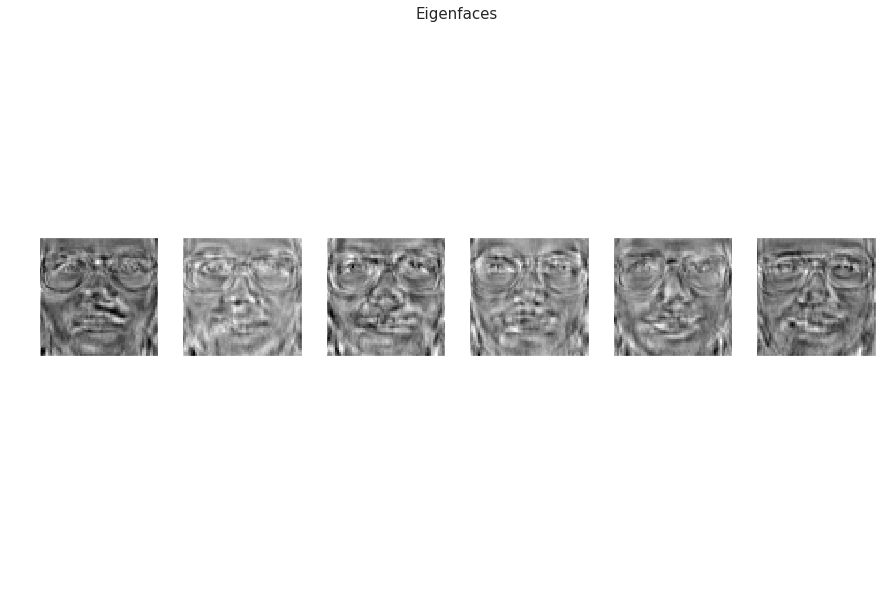

In [27]:
#lets see how these eigenfaces/eigenvectors look like:
fig1 = plt.figure(figsize=(15, 10))
plt.title('Eigenfaces')
plt.axis("off")
for i in range(30):
    a = fig1.add_subplot(5,6,i+1)
    eigenfaces=u[:,i].reshape(image_shape)
    showfig(eigenfaces)
    
#distant eigenfaces
fig1 = plt.figure(figsize=(15, 10))
plt.title('Eigenfaces')
plt.axis("off")
skip = 100
for i in range(skip, skip+6):
    a = fig1.add_subplot(1,6,i+1-skip)
    eigenfaces=u[:,i].reshape(image_shape)
    showfig(eigenfaces)

In [28]:
Y = u[:,:20].T.dot(B)
re = mean_face.reshape([mean_face.shape[0],1]) + u[:,:20].dot(Y)

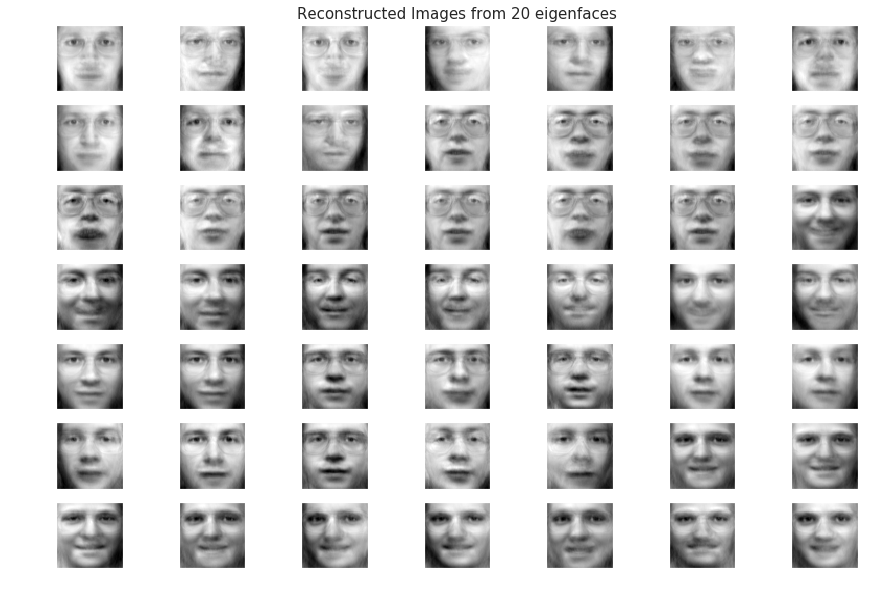

In [29]:
# lets plot the reconstructed images.
fig2 = plt.figure(figsize=(15, 10))
plt.title('Reconstructed Images from 20 eigenfaces')
plt.axis("off")
for i in range(49):
    re1 = re[:,i].reshape(image_shape)
    fig2.add_subplot(7,7,i+1)
    showfig(re1)

Test with 1 picture:

I found 1 face(s) in this photograph.
A face is located at pixel location Top: 39, Left: 17, Bottom: 101, Right: 80


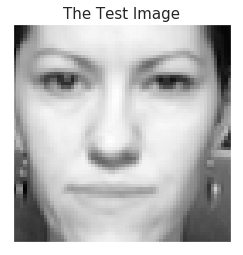

In [30]:
#path of the training images
path_test = "my_photo_test"
test_files = get_imlist(path_test)
new_face = face_detect(test_files[0])
fig = plt.figure(figsize=[4,4])
plt.title('The Test Image')
showfig(new_face.reshape(image_shape))

In [31]:
new_face = scale(new_face)
test_f = new_face

#We have already projected our training images into pca subspace as Y.
train_proj = Y

#Projecting our test image into PCA subspace
test_proj = u[:,:20].T.dot(test_f)
print(train_proj.shape)
print(test_proj.shape)

(20, 405)
(20,)


In [32]:
def norm_2(v1, v2):
    return np.linalg.norm(v1-v2, 2)

In [33]:
errs = np.array([], dtype=float)
for i in range(train_proj.shape[1]):
    e = norm_2(test_proj.flatten(), train_proj[:,i].flatten())
    errs = np.append(errs, e)
min_distance_index = np.argmin(errs)
print(min_distance_index, errs[min_distance_index])

55 36.477242633786865


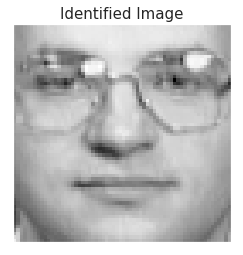

In [34]:
identified = (faces_images[min_distance_index,:]).reshape(image_shape)
plt.title('Identified Image')
showfig(identified)

#### Кросс-валидация

In [35]:
class Face_Detector:
    def __init__(self, face_mtx, target):
        self.mean_face = np.mean(face_mtx, axis=0)
        self.Matrix = face_mtx - self.mean_face
        self.target = target
        self.face_basis = None
        self.train_proj = None
        self.errs = None
    
    def fit(self):
        B = np.copy(self.Matrix.T)
        r = np.linalg.matrix_rank(B)
        u, s, vh = np.linalg.svd(B)
        self.face_basis = u[:,:r]
        self.train_proj = self.face_basis.T.dot(B)
    
    def predict(self, new_face, treshold):
        test_f = new_face - self.mean_face
        test_proj = self.face_basis.T.dot(test_f)
        self.errors = np.array([], dtype=float)
        
        for i in range(self.train_proj.shape[1]):
            e = norm_2(test_proj.flatten(), self.train_proj[:,i].flatten())
            self.errors = np.append(self.errors, e)
        min_distance_index = np.argmin(self.errors)

        error = self.errors[min_distance_index]
        if error > treshold:
            return -1, error
        return self.target[min_distance_index], error

In [29]:
def get_predictions(faces, faces_ids, sample_amount=50, treshold=50):    
    # Positive test
    unq, unq_idx, unq_cnt = np.unique(faces_ids, return_inverse=True, return_counts=True)
    repeated_ids = unq[unq_cnt > 1]
    repeated_ids_idxs = np.argwhere(np.isin(faces_ids, repeated_ids)).flatten()
    positive_faces_idxs = np.random.choice(repeated_ids_idxs, sample_amount, replace=False)
    positive_test_ids = faces_ids[positive_faces_idxs]
    
    # Negative test
    # Select sample_amount faces and completely remove them from train
    # Assign target None to them
    ids_not_used_in_positive_test = faces_ids[ ~np.isin(faces_ids, positive_test_ids) ]
    negative_test_ids = np.random.choice(ids_not_used_in_positive_test, sample_amount, replace=False)
    negative_faces_idxs = np.argwhere(np.isin(faces_ids, negative_test_ids)).flatten()
    
    negative_test_ids = faces_ids[negative_faces_idxs]
    
    test_face_idxs = list(negative_faces_idxs)+list(positive_faces_idxs)
    test_ids = list(negative_test_ids)+list(positive_test_ids)
    
    train_faces = np.delete(faces, test_face_idxs, axis=0)
    train_faces_ids = np.delete(faces_ids, test_face_idxs, axis=0)
    
#     print('test faces pos rows', positive_faces_idxs)
#     print('test faces neg rows', negative_faces_idxs)
#     print('initial rows', faces.shape[0])
#     print('positive_rows_deleted', len(positive_faces_idxs))
#     print('negative rows deleted', len(negative_faces_idxs))
#     print('final rows', len(train_faces))
    
    negative_test_faces_idxs = np.random.choice(negative_faces_idxs, sample_amount, replace=False)
    negative_test_ids = faces_ids[negative_test_faces_idxs]
    
    test_face_idxs = list(negative_test_faces_idxs)+list(positive_faces_idxs)
    test_ids = list(negative_test_ids)+list(positive_test_ids)
    expected_ids = [-1 for i in negative_test_ids] + list(positive_test_ids)
    
    #print('Test face indices', test_face_idxs)
    #print('test ids', test_ids)
    #print('expected test ids', expected_ids)
    
    #### 
    
    
    # None values for which the classifier should output None
    # Integer values for which the classifier should output an id
    
    
    detector = Face_Detector(train_faces, train_faces_ids)
    detector.fit()
        
    predicted_ids = []
    errors = []

    for i in test_face_idxs:
        test_face = faces[i, :]
        test_face_id = faces_ids[i]            
        predicted_id, error = detector.predict(test_face, treshold=treshold)
        predicted_ids.append(predicted_id)
        errors.append(error)
    #print(predicted_ids)
    return expected_ids, predicted_ids, errors

sample_amount = 50
max_treshold_score = None
max_treshold = None

tresholds = np.linspace(1, 15, 100)
# Crudely find where our best treshold lies

scores = []

for treshold in tresholds:
    print('treshold', treshold)
    true_y, predicted_y, errors = get_predictions(faces_images,
                                                  faces_ids,
                                                  sample_amount=sample_amount,
                                                  treshold=treshold)
    #print(errors)
    score = f1_score(true_y, predicted_y, average='weighted')
    print('F1 score weighted', score)
    
    #score = f1_score(true_y[sample_amount:], predicted_y[sample_amount:], average='weighted')
    #print('F1 score weighted positive', score)
    
    if not max_treshold_score or score > max_treshold_score:
        max_treshold = treshold
        max_treshold_score = score
        
        print(true_y)
        print(predicted_y)
    scores.append(score)
    
print('best', max_treshold)

treshold 1.0
F1 score weighted 0.33333333333333326
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 34, 19, 13, 12, 35, 15, 32, 7, 13, 12, 22, 40, 20, 18, 27, 25, 30, 0, 7, 15, 27, 21, 13, 22, 10, 6, 29, 10, 32, 28, 1, 34, 23, 24, 29, 28, 13, 28, 39, 31, 2, 7, 24, 23, 35, 25, 38, 4, 0, 25]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
treshold 1.1414141414141414
F1 score weighted 0.33333333333333326
treshold 1.2828282828282829
F1 score weighted 0.33333333333333326
treshold 1.4242424242424

F1 score weighted 0.5664676616915423
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 1, 33, 18, 29, 22, 26, 31, 10, 16, 7, 18, 38, 36, 36, 39, 20, 26, 37, 25, 40, 18, 29, 32, 1, 30, 31, 12, 21, 27, 14, 39, 17, 2, 29, 28, 32, 19, 12, 22, 10, 7, 20, 28, 22, 39, 26, 35, 12, 32]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 33, 18, -1, -1, -1, -1, -1, -1, -1, -1, 38, -1, 36, 39, -1, -1, -1, -1, -1, -1, -1, -1, -1, 30, -1, -1, -1, 27, 14, -1, -1, 2, 29, -1, -1, 19, -1, -1, -1, 7, 20, -1, -1, -1, 26, 35, -1, -1]
treshold 3.9696969696969697
F1 score weighted 0.5316301703163017
treshold 4.111111111111111
F1 score weighted 0.5930127226463103
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

F1 score weighted 0.4796001221001221
treshold 8.212121212121211
F1 score weighted 0.6388535891968727
treshold 8.353535353535353
F1 score weighted 0.545607142857143
treshold 8.494949494949495
F1 score weighted 0.5034164186050596
treshold 8.636363636363637
F1 score weighted 0.3998693266900814
treshold 8.777777777777779
F1 score weighted 0.3881708357002474
treshold 8.919191919191919
F1 score weighted 0.39951251526251524
treshold 9.06060606060606
F1 score weighted 0.4027852425352425
treshold 9.202020202020202
F1 score weighted 0.5122514619883042
treshold 9.343434343434343
F1 score weighted 0.3948736263736264
treshold 9.484848484848484
F1 score weighted 0.3757460317460318
treshold 9.626262626262626
F1 score weighted 0.38954723707664884
treshold 9.767676767676768
F1 score weighted 0.371952380952381
treshold 9.909090909090908
F1 score weighted 0.3643528138528139
treshold 10.05050505050505
F1 score weighted 0.35164646464646465
treshold 10.191919191919192
F1 score weighted 0.35222710622710623
t

In [36]:
import seaborn as sns
import pandas as pd

#scores = np.round(np.array(scores), 2)
#tresholds = np.round(np.array(tresholds), 3)
df = pd.DataFrame({'score': scores, 'treshold': tresholds})
plt.figure(figsize=(15, 10))
plt.axvline(x=max_treshold)
plt.title('F1 score weighted')
sns.lineplot('treshold', 'score', data=df)

NameError: name 'scores' is not defined

In [38]:
# left_idx = max(np.argwhere(tresholds==max_treshold)[0]-1, 0)
# left = tresholds[left_idx]
# right_idx = min(np.argwhere(tresholds==max_treshold)[0]+1, len(tresholds)-1)
# right = tresholds[right_idx]
# print('Searching for treshold between: ',left, right)

# max_treshold_score = None
# max_treshold = None

# # Find it accurately
# for treshold in np.linspace(left, right, 10):
#     print('treshold', treshold)
#     true_y, predicted_y, errors = get_predictions(faces_images,
#                                                   faces_ids,
#                                                   sample_amount=sample_amount,
#                                                   treshold=treshold)
#     score = f1_score(true_y, predicted_y, average='weighted')
#     print('F1 score weighted', score)
#     if not max_treshold_score or score > max_treshold_score:
#         max_treshold = treshold
#         max_treshold_score = score
        
# print('Best treshold', max_treshold)

I found 1 face(s) in this photograph.
A face is located at pixel location Top: 39, Left: 17, Bottom: 101, Right: 80


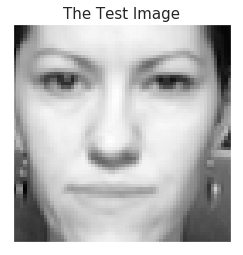

In [39]:
# Test with 1 picture using treshold
path_test = "my_photo_test"
test_files = get_imlist(path_test)
new_face = face_detect(test_files[0])
fig = plt.figure(figsize=[4,4])
plt.title('The Test Image')
showfig(new_face.reshape(image_shape))
new_face = scale(new_face)
test_f = new_face

40 9.15579845075137


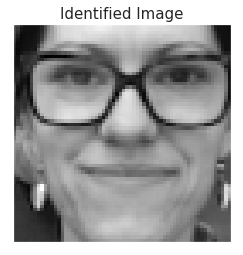

In [43]:
t = max_treshold = 10
detector = Face_Detector(faces_images, faces_ids)
detector.fit()
predicted_id, error = detector.predict(test_f, treshold=t)
print(predicted_id, error)
if predicted_id != -1:
    predicted_index = np.argwhere(faces_ids==predicted_id)[0][0]
    predicted_face = faces_images[predicted_index, :]
    identified = predicted_face.reshape(image_shape)
    fig = plt.figure(figsize=[4,4])
    plt.title('Identified Image')
    showfig(identified)
else:
    print('Not recognized')

out_of_train_test/lucy-recon-big.ngsversion.1531251865727.adapt.1900.1.jpg
I found 1 face(s) in this photograph.
A face is located at pixel location Top: 192, Left: 510, Bottom: 1150, Right: 1469
-1 12.44517562217127
Not recognized

out_of_train_test/800px-President_Vladimir_Putin.jpg
I found 1 face(s) in this photograph.
A face is located at pixel location Top: 246, Left: 91, Bottom: 708, Right: 553
-1 10.155079822847435
Not recognized

out_of_train_test/MV5BMTQzMjkwNTQ2OF5BMl5BanBnXkFtZTgwNTQ4MTQ4MTE@._V1_UY317_CR18,0,214,317_AL_.jpg
I found 1 face(s) in this photograph.
A face is located at pixel location Top: 92, Left: 55, Bottom: 199, Right: 163
-1 7.616831453629168
Not recognized

out_of_train_test/Gladys_Stone_gorilla_at_Cincinnati_Zoo_20130301114412_640_480.jpg
I found 1 face(s) in this photograph.
A face is located at pixel location Top: 167, Left: 216, Bottom: 390, Right: 439
-1 9.214503805222071
Not recognized



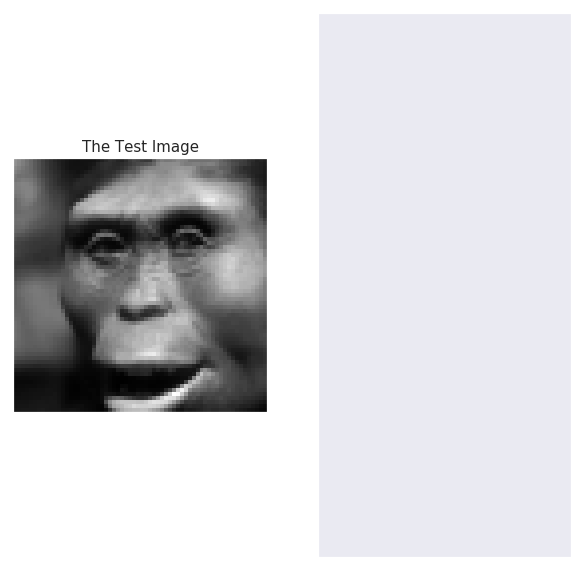

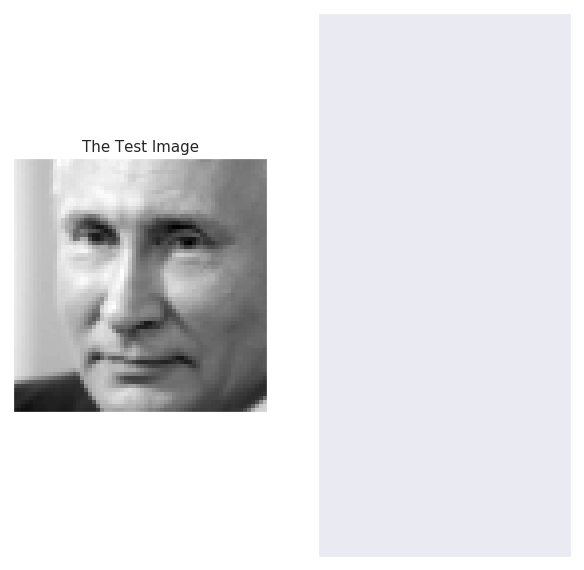

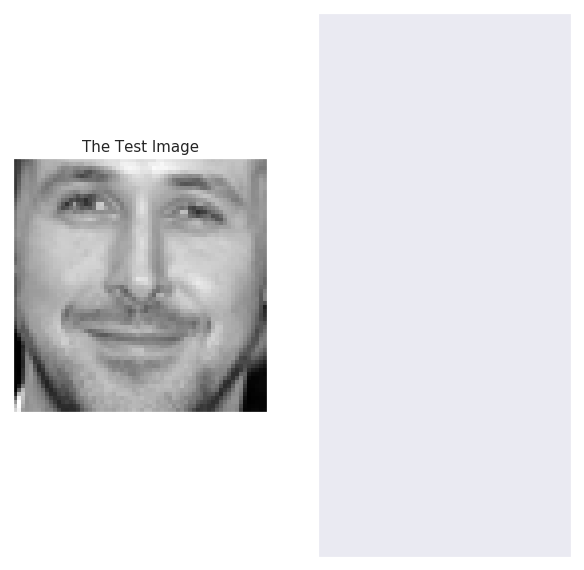

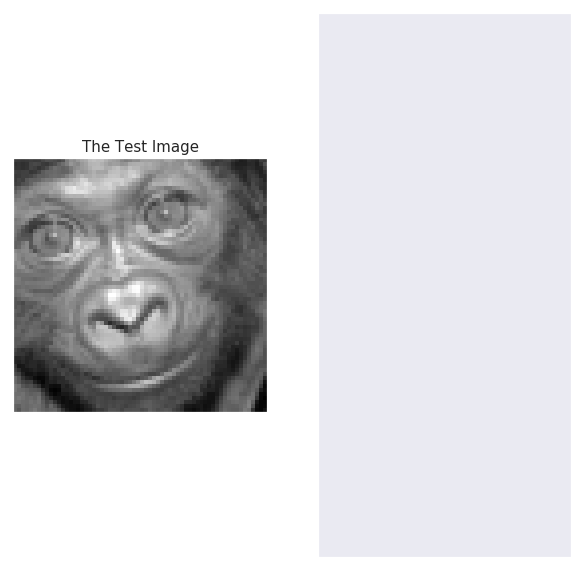

In [42]:
# Test with 1 picture not from train using treshold
def load_image(path):  
    new_face = face_detect(path)
    new_face = scale(new_face)
    return new_face

path_test = "out_of_train_test"
test_files = get_imlist(path_test)

#t = 19.2
for f in test_files:
    print(f)
    new_face = load_image(f)
    fig = plt.figure(figsize=[10,10])
    ax1, ax2 = fig.subplots(1, 2)
    ax1.set_title('The Test Image')
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
        
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    showfig(new_face.reshape(image_shape), ax=ax1)

    predicted_id, error = detector.predict(new_face, treshold=t)
    print(predicted_id, error)
    if predicted_id != -1:
        predicted_index = np.argwhere(faces_ids==predicted_id)[0][0]
        predicted_face = faces_images[predicted_index, :]
        identified = predicted_face.reshape(image_shape)
        ax2.set_title('Identified Image')
        showfig(identified, ax=ax2)
    else:
        print('Not recognized')
    print('')

#### Decomposition with PCA function

In [ ]:
from sklearn.decomposition import PCA

mean_face = faces_images.mean(axis=0)
red = PCA()
faces_images -= mean_face
red.fit(faces_images)

plt.figure(figsize=(16, 16))
rows, cols = 4, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(red.components_[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

gscv_rf = GridSearchCV(RandomForestClassifier(),
                       {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]},
                       cv=5)

In [ ]:
%%time

gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

In [ ]:
%%time

# gscv_rf.fit(red.transform(faces_images)[:,:100], faces_ids)
proj = u[:,:100].T.dot(B)
gscv_rf.fit(proj.T, faces_ids)
print(gscv_rf.best_score_)

#### Эксперименты с изменением матриц

In [ ]:
plt.rcParams['figure.figsize'] = 4, 4
test_img1 = (faces_images[20,:]+mean_face).reshape(image_shape)
showfig(test_img1)

In [ ]:
plt.rcParams['figure.figsize'] = 4, 4
test_img2 = (faces_images[79,:]+mean_face).reshape(image_shape)
showfig(test_img2)

#### Раскладываем лица в SVD

In [ ]:
test_img1 = misc.imresize(test_img1, [k1,k2])
test_img2 = misc.imresize(test_img2, [k1,k2])
u1, s1, vh1 = np.linalg.svd(test_img1)
u2, s2, vh2 = np.linalg.svd(test_img2)

In [ ]:
Sigma1 = np.zeros((test_img1.shape[0], test_img1.shape[1]))
Sigma2 = np.zeros((test_img2.shape[0], test_img2.shape[1]))
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.diag(s1)
Sigma2[:test_img2.shape[1], :test_img2.shape[1]] = np.diag(s2)

In [ ]:
Sigma1

Соберем разложенные лица обратно, поменяв местами их матрицы с сингулярными числами

In [ ]:
re_img1 = u1.dot(Sigma2.dot(vh1))
re_img2 = u2.dot(Sigma1.dot(vh2))

test_img = np.array([test_img1, re_img1, test_img2, re_img2])

In [ ]:
fig1 = plt.figure(figsize=(6,6))
plt.title('2 faces after changing their Sigma matricies')
plt.axis("off")
for i in range(4):
    a = fig1.add_subplot(2,2,i+1)
    face = misc.imresize(test_img[i], image_shape)
    showfig(face)

Видим, что поменялся немного контраст, но лица остались прежними

Пробуем менять сингулярные числа в разложении одного какого-то лица, должен меняться контраст, яркость, резкость - лицо остается прежним.

In [ ]:
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.add(np.diag(s1), s1[0]*0.0005)
re_tone_img1 = u1.dot(Sigma1.dot(vh1))
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.square(np.diag(s1))
re_tone_img2 = u1.dot(Sigma1.dot(vh1))
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.multiply(np.diag(s1), 0.8)
re_tone_img3 = u1.dot(Sigma1.dot(vh1))
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.sqrt(np.diag(s1))
re_tone_img4 = u1.dot(Sigma1.dot(vh1))
set_img = np.array([test_img1, re_tone_img1, re_tone_img2, re_tone_img3, re_tone_img4])

fig1 = plt.figure(figsize=(15,3))
plt.title('Experiments1')
plt.axis("off")

for i in range(5):
    a = fig1.add_subplot(1,5,i+1)
    face = misc.imresize(set_img[i], image_shape)
    showfig2(face)

In [ ]:
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.add(np.diag(s1), 30)
re_tone_img1 = u1.dot(Sigma1.dot(vh1))
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.add(np.diag(s1), -30)
re_tone_img2 = u1.dot(Sigma1.dot(vh1))
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.multiply(np.diag(s1), s1[0])
re_tone_img3 = u1.dot(Sigma1.dot(vh1))
Sigma1[:test_img1.shape[1], :test_img1.shape[1]] = np.add(np.diag(s1), np.log(s1)* 0.1)
re_tone_img4 = u1.dot(Sigma1.dot(vh1))
set_img = np.array([test_img1, re_tone_img1, re_tone_img2, re_tone_img3, re_tone_img4])

fig1 = plt.figure(figsize=(15,3))
plt.title('Experiments2')
plt.axis("off")

for i in range(5):
    a = fig1.add_subplot(1,5,i+1)
    face = misc.imresize(set_img[i], image_shape)
    showfig2(face)

Поменяем местами несколько строк в левой матрице SVD разложения для лица, соберем обратно

In [ ]:
plt.rcParams['figure.figsize'] = 4, 4
u1, s1, vh1 = np.linalg.svd(test_img1)
u1_mixed = np.copy(u1)
u1_mixed[:20, :], u1_mixed[40:60, :] = u1[40:60, :], u1[:20, :]
mixed_img1 = u1_mixed.dot(Sigma1.dot(vh1))
showfig(mixed_img1)

Собственно из этого эксперимента видно, что у нас ключевая инфа о лице содержится не в самих сингулярных значениях, а в остальных. Матрица с сигнулярными числами отвечает за яркость, контраст, резкость и т д.

In [ ]:
u2, s2, vh2 = np.linalg.svd(test_img1)
vh2_mixed = np.copy(vh2)
vh2_mixed[:20, :], vh2_mixed[40:60, :] = vh2[40:60, :], vh2[:20, :]
mixed_img1 = u2.dot(Sigma1.dot(vh2_mixed))
showfig(mixed_img1)